# 1) The Problem

The problem at hand is the detection of the malaria parasite in a cell.

# Preformance Metrics

The metrics by which our model will be evaluated is the accuracy of the classification. Due to a possibility of limited supplies in the area where this model would be best implemented precision and recall are equally important. We don’t want to be too conservative with the positive test as this could cause avoidable deaths, but it is important to not waste supplies.

# Why is this important?

The problem is worthwhile as many rural areas in sub-Saharan Africa and rural India are plagued with this disease yet lack the medical equipment to detect the parasite accurately or in a timely manner.

#  2) Collection/Discussion of Data

The data collected for this model was provided by www.kaggle.com. The images in this dataset are pictures of, mostly, individual cells that have been identified as uninfected or parasitized.

# 3) Data Analysis

# Code

In [1]:
# Imports for model and image manipulation, dataset creation, and evaluation.
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import color
from sklearn.model_selection import train_test_split
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D,MaxPooling2D,Dropout,Flatten,BatchNormalization,Activation,Dense,Dropout)
from sklearn.metrics import (accuracy_score,classification_report,confusion_matrix,plot_confusion_matrix)
import itertools
from sklearn.metrics import confusion_matrix

In [2]:
# Creates a path to the image files.
images_path = os.path.join(os.getcwd(),"cell_images")

In [3]:
# Get random numbers(used as indices for arrays of images.)
def getRandomIndex(desired_range,num_indecies=3):
    randoms = list()
    for i in range(num_indecies):
        randoms.append(random.randint(0,desired_range))
    return randoms

In [4]:
# Creates an array of tuples with the image(in nparray form) and the label.
def makeDataset(dataset_array,image_array,labels):
    for feature,label in zip(image_array,labels):
        dataset_array.append((feature,label))

In [5]:
# Converts dataset into a feature label array.
def makeXYSets(dataset,x,y):
    for feature,label in dataset:
        x.append(feature)
        y.append(label) 

In [6]:
'''Class to explore, retrieve, preprocess, and lightly engineer the 
image. Provides method to convert to nparray. Supports png, jpg, jpeg.'''
class imagePreprocessor:
    
    '''Creates a preprocessor object with data fields image class,
    a dictionary with the images and file name, the path to retrieve images,
    a statistics field for mean and standard deviation of the resolutions,
    the type(png,jpg,nparray). This constructor will also create a directory
    for contain the images.'''
    def __init__(self,image_class,path):
        self.image_class = image_class
        self.image_data = {
            "file_names": list(),
            "images": list()
        }
        self.num_images = len(self.image_data["images"])
        self.image_path = os.path.join(path,image_class)
        self.image_stats = None
        self.image_type = None
        self.type = None
        self.makePreprocessDir()
    
    # Makes a directory for the manipulated images to be stored as to preserve the originals.
    def makePreprocessDir(self):
        try:
            os.mkdir(os.path.join(os.getcwd(),"Preprocessed_Images"))
        except OSError:
            None
        try:
            os.mkdir(os.path.join(os.getcwd(),"Preprocessed_Images",self.image_class))
        except OSError: 
            None
       
    # Calculates resolution from pillow object member data .size.
    @staticmethod
    def getResolution(image_dimentions):
        (h,v) = image_dimentions
        return h*v
    
    # Sets image_path to the preprocessed folder and clears the image array for new data to be loaded.
    def clearImages(self):
        self.image_data["images"].clear()
        self.image_path = os.path.join(os.getcwd(),"Preprocessed_Images",self.image_class)
    
    # Clears file names.
    def clearNames(self):
        self.image_data["file_names"].clear()
    
    # Shows n images and returns their information (resolution, format, mode).
    def previewImages(self,n_images):
        files = os.listdir(self.image_path)
        samples = random.choices(files,k=n_images)
        print(self.image_class)
        for file in samples:
            if(file.endswith("png") or file.endswith("jpg") or file.endswith("jpeg")):
                image = Image.open(os.path.join(self.image_path,file))
                print(file)
                print(image.size)
                print(self.getResolution(image.size))
                print(image.mode)
                print(image.format)
                image.show()
                image.close()
                self.image_type = image.format.lower()
                self.type = image.format.lower()
    
    # Shows 3 images in a plot.
    def showImages(self,color='gray'):
        indecies = getRandomIndex(self.num_images-1)
        
        fig, (img0,img1,img2) = plt.subplots(1,3,figsize=(10,10))
        
        image = self.image_data["images"][indecies[0]]
        img0.axis("off")
        img0.imshow(image,cmap=color)
        img0.set_title(self.image_class+'1')
        
        image = self.image_data["images"][indecies[1]]
        img1.axis("off")
        img1.imshow(image,cmap=color)
        img1.set_title(self.image_class+'2')
        
        image = self.image_data["images"][indecies[2]]
        img2.axis("off")
        img2.imshow(image,cmap=color)
        img2.set_title(self.image_class+'3')
            
    # Loads n images into an array for preprocessing.
    def retrieveImages(self,n_images=100000):
        for file,i in zip(os.listdir(self.image_path),range(n_images)):
            if(file.endswith("png") or file.endswith("jpg") or file.endswith("jpeg")):
                image = Image.open(os.path.join(self.image_path,file))
                self.image_data["file_names"].append(file)
                self.image_data["images"].append(image)
                image.close()
        self.num_images = len(self.image_data["images"])
        print(self.image_class+"\nNumber of images: %d" % len(self.image_data["images"]))
    
    # Gets the min, max resolution image, the average resolution and the standard deviation.
    def getImageStats(self):
        max_res = 0
        min_res = 1000000000
        res_array = list()
        
        for image in self.image_data["images"]:
            res = self.getResolution(image.size)
            res_array.append(res)
            if(res > max_res):
                max_res = res
            if(res < min_res):
                min_res = res
                      
        average_res = np.mean(res_array)
        std_res = np.std(res_array)
            
        image_stats = ("Lowest Resolution", min_res,
                        "Higest Resolution", max_res,
                        "Average Resolution", average_res,
                        "Standard Deviation", std_res)
            
        print(self.image_class+"\n",image_stats)
        self.image_stats = (average_res,std_res)
    
    # Removes outliers specified by s standard deviations n times. Recalculates image stats each time.
    def removeOutliers(self,s_deviations=3,n_iterations=1):
        for i in range(n_iterations):
            (mean,deviation) = self.image_stats
            deviations = deviation*s_deviations
            curr = 0
            
            for image in self.image_data["images"]:
                if(self.getResolution(image.size) >= mean+deviations or self.getResolution(image.size) <= mean-deviations):
                    del self.image_data["file_names"][curr]
                    del self.image_data["images"][curr]
                curr += 1
            
            self.getImageStats()
            print("Remaining Images:%d" % len(self.image_data["images"]))
            
        self.num_images = len(self.image_data["images"])
    
    # Converts all images to a standard resolution. Then clears the list and saves the new images to the preprocessed directory.
    def standardizeResolution(self,desired_resolution):
        curr = 0
        for file,n in zip(os.listdir(self.image_path),range(self.num_images)):
            if(curr == len(self.image_data["file_names"])):
                break
            if(file == self.image_data["file_names"][curr]):
                image = cv2.imread(os.path.join(self.image_path,file))
                image = cv2.resize(image,desired_resolution)
                cv2.imwrite(os.path.join(os.getcwd(),"Preprocessed_Images",self.image_class,file),image)
                curr += 1
                
        self.clearImages()
        
        # Plots 3 random images with the new resolution.
        indecies = getRandomIndex(len(self.image_data["file_names"])-1)
        
        fig, (img0,img1,img2) = plt.subplots(1,3,figsize=(10,10))
        
        image = cv2.imread(os.path.join(self.image_path,self.image_data["file_names"][indecies[0]]))
        img0.axis("off")
        img0.imshow(image)
        img0.set_title(self.image_class+'1')
        
        image = cv2.imread(os.path.join(self.image_path,self.image_data["file_names"][indecies[1]]))
        img1.axis("off")
        img1.imshow(image)
        img1.set_title(self.image_class+'2')
        
        image = cv2.imread(os.path.join(self.image_path,self.image_data["file_names"][indecies[2]]))
        img2.axis("off")
        img2.imshow(image)
        img2.set_title(self.image_class+'3')
    
    # Create a bounding box around the image (edge detection). Offset allows for a smaller box to be created.
    def boundingBox(self,image_path,offset=0,show=False):
        temp = (0,0,0,0)
        image = cv2.imread(image_path)
        gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        
        # Highlights a change in pixel intencity.
        thresh = cv2.threshold(gray,100,255,cv2.THRESH_OTSU + cv2.THRESH_BINARY)[1]
        
        # Finds the regions in the image and returns bounding box cordinates.
        contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = contours[0] if len(contours) == 2 else contours[1]

        ROI_number = 0
        for contour in contours:
            x,y,w,h = cv2.boundingRect(contour)
            ROI = image[y:y+h, x:x+w]
            w = x+w-offset
            h = y+h-offset
            x += offset
            y += offset
            cv2.rectangle(image,(x,y),(w,h),(36,255,12),2)
            ROI_number += 1
            
            temp = (x,y,w,h)
        if(show == True):
            cv2.imshow('thresh', thresh)
            cv2.imshow(self.image_class, image)
            cv2.waitKey()
            cv2.destroyAllWindows()
        
        return temp
        
    # Shows the bounding boxes of n images.
    def viewBoundingBox(self,n_images,offset=0):
        for i in range(n_images):
            file = os.listdir(self.image_path)
            file = file[random.randint(0,len(file)-1)]
            if(file.endswith(self.image_type)):
                image_path = os.path.join(self.image_path,file)
                self.boundingBox(image_path,offset,show=True)
        
    
    # Converts all images in preprocessed directory to a np array for further processing and training.
    def convert2NP(self):
        self.type = "nparray"
        curr = 0
        for file,n in zip(os.listdir(self.image_path),range(self.num_images)):
            if(file == self.image_data["file_names"][curr]):
                image = cv2.imread(os.path.join(self.image_path,file))
                pixel_image = np.asarray(image)
                self.image_data["images"].append(pixel_image)
                curr += 1
        
        self.num_images = len(self.image_data["images"])
    
    # Grayscales images.
    def grayscaleImages(self):
        for i in range(len(self.image_data["images"])):
            self.image_data["images"][i] = color.rgb2gray(self.image_data["images"][i])
    
        self.showImages()

    # Finds an inner region and highlights darker sections so the gradient is drastic.
    def magnifyGradient(self,pixel_range,offset=0):
        curr = 0 
        for file,n in zip(os.listdir(self.image_path),range(self.num_images)):
            if(file == self.image_data["file_names"][curr]):
                (x,y,w,h) = self.boundingBox(os.path.join(self.image_path,file),offset)
                for i in range(len(self.image_data["images"][curr])):
                    for j in range(len(self.image_data["images"][curr][i])):
                        if(self.image_data["images"][curr][i][j] < pixel_range):
                            if(i>y and j>x and i<h and j<w):
                                self.image_data["images"][curr][i][j] = 1
                            else:
                                center0 = int (len(self.image_data["images"][curr])/2)
                                center1 = int (len(self.image_data["images"][curr][i])/2)
                                self.image_data["images"][curr][i][j] = self.image_data["images"][curr][center0][center1]
                curr += 1
        
        self.showImages()
    
    # Returns the image array in the member dictionary.
    def getImages(self):
        return self.image_data["images"]

In [7]:
# Class to preprocess numpy arrays normalization, centering, labeling and creating a gradient.
class npImagePreprocessor():
    
    # Constructs an object containing the nparray and class name. The object has member data for the gradients and labels.
    def __init__(self,image_array,image_class):
        self.image_class = image_class
        self.images_array = image_array
        self.horizontal_gradients = None
        self.vertical_gradients = None
        self.labels = None
    
    # Normalizes pixels of the image 0-1.
    def normalizePixels(self):
        for x in range(len(self.images_array)):
            temp = self.images_array[x]
            temp /= temp.max()
            self.images_array[x] = temp
    
    # Centers pixels of the image on 0.
    def centerPixels(self):
        for x in range(len(self.images_array)):
            temp = self.images_array[x]
            temp = temp - temp.mean()
            self.images_array[x] = temp
    
    # Creates an image with a horizontal and vertical gradient of the source image.
    def gradient(self):
        h = list()
        v = list()
        for image in self.images_array:
            sobely = cv2.Sobel(image,cv2.CV_64F,0,1,ksize=7)
            h.append(sobely)
            sobelx = cv2.Sobel(image,cv2.CV_64F,1,0,ksize=7)
            v.append(sobelx)
        self.horizontal_gradients = h
        self.vertical_gradients = v
    
    # Plots 3 images if the gradient arrays are not null those are ploted as well(3 of each).
    def showImages(self,color='gray'):
        indecies = getRandomIndex(len(self.images_array)-1)
        
        if(self.horizontal_gradients != None and self.vertical_gradients != None):
            fig, (imgNP,imgHP,imgVP) = plt.subplots(3,3,figsize=(10,10))

            print(self.image_class)

            imgNP[0].axis('off')
            imgNP[0].imshow(self.images_array[indecies[0]],cmap='gray')
            imgNP[0].set_title('Normal 1')

            imgNP[1].axis('off')
            imgNP[1].imshow(self.images_array[indecies[1]],cmap='gray')
            imgNP[1].set_title('Normal 2')

            imgNP[2].axis('off')
            imgNP[2].imshow(self.images_array[indecies[2]],cmap='gray')
            imgNP[2].set_title('Normal 3')

            imgHP[0].axis('off')
            imgHP[0].imshow(self.horizontal_gradients[indecies[0]],cmap='gray')
            imgHP[0].set_title('Horizontal Gradients 1')

            imgHP[1].axis('off')
            imgHP[1].imshow(self.horizontal_gradients[indecies[1]], cmap='gray')
            imgHP[1].set_title('Horizontal Gradients 2')

            imgHP[2].axis('off')
            imgHP[2].imshow(self.horizontal_gradients[indecies[2]], cmap='gray')
            imgHP[2].set_title('Horizontal Gradients 3')

            imgVP[0].axis('off')
            imgVP[0].imshow(self.vertical_gradients[indecies[0]], cmap='gray')
            imgVP[0].set_title('Vertical Gradients 0')

            imgVP[1].axis('off')
            imgVP[1].imshow(self.vertical_gradients[indecies[1]], cmap='gray')
            imgVP[1].set_title('Vertical Gradients 1')

            imgVP[2].axis('off')
            imgVP[2].imshow(self.vertical_gradients[indecies[2]], cmap='gray')
            imgVP[2].set_title('Vertical Gradients 2')
        
        
        else:
        
            fig, (img0,img1,img2) = plt.subplots(1,3,figsize=(10,10))

            img0.axis("off")
            img0.imshow(self.images_array[indecies[0]],cmap=color)
            img0.set_title(self.image_class+'1')

            img1.axis("off")
            img1.imshow(self.images_array[indecies[1]],cmap=color)
            img1.set_title(self.image_class+'2')

            img2.axis("off")
            img2.imshow(self.images_array[indecies[2]],cmap=color)
            img2.set_title(self.image_class+'3')
    
    # Makes labels for the class (binary classifier 0 and 1).
    def makeLabels(self,image_class):
        self.labels = list()
        for x in range(len(self.images_array)):
            if(image_class == 0):
                self.labels.append((1,0))
            if(image_class == 1):
                self.labels.append((0,1))

Creates a preprocessor object for the two class directories.

In [8]:
uninfected_images = imagePreprocessor("Uninfected",images_path)
parasitized_images = imagePreprocessor("Parasitized",images_path)

Previews five images and prints their information (file name, resolution (h,v), resolution (h*v), mode, and file extention.

In [9]:
uninfected_images.previewImages(5)
parasitized_images.previewImages(5)

Uninfected
C51AP12thinF_IMG_20150724_154330_cell_70.png
(127, 118)
14986
RGB
PNG
C149P110ThinF_IMG_20151115_115154_cell_30.png
(133, 118)
15694
RGB
PNG
C127P88ThinF_IMG_20151004_111651_cell_21.png
(127, 115)
14605
RGB
PNG
C159P120ThinF_IMG_20151115_190642_cell_145.png
(121, 118)
14278
RGB
PNG
C203ThinF_IMG_20151029_102123_cell_128.png
(151, 154)
23254
RGB
PNG
Parasitized
C49P10thinF_IMG_20150724_102330_cell_226.png
(124, 112)
13888
RGB
PNG
C68P29N_ThinF_IMG_20150819_133236_cell_187.png
(148, 148)
21904
RGB
PNG
C175P136NThinF_IMG_20151127_141428_cell_218.png
(121, 145)
17545
RGB
PNG
C184P145ThinF_IMG_20151203_104030_cell_31.png
(139, 163)
22657
RGB
PNG
C97P58ThinF_IMG_20150917_152437_cell_7.png
(115, 157)
18055
RGB
PNG


Loads all the images into the preprocessor object. Returns number of images loaded.

In [10]:
uninfected_images.retrieveImages()
parasitized_images.retrieveImages()

Uninfected
Number of images: 13779
Parasitized
Number of images: 13779


Retrieves image statistics lowest, highest resolution average resolution and standard deviation.

In [11]:
uninfected_images.getImageStats()
parasitized_images.getImageStats()

Uninfected
 ('Lowest Resolution', 2842, 'Higest Resolution', 47080, 'Average Resolution', 17456.62007402569, 'Standard Deviation', 4345.016459624351)
Parasitized
 ('Lowest Resolution', 2200, 'Higest Resolution', 123760, 'Average Resolution', 18214.89266274766, 'Standard Deviation', 5494.095320072288)


Preliminary removal of outliers one iteration three standard deviations.

In [12]:
uninfected_images.removeOutliers()
parasitized_images.removeOutliers()

Uninfected
 ('Lowest Resolution', 4480, 'Higest Resolution', 40579, 'Average Resolution', 17290.565029325513, 'Standard Deviation', 3981.9228661414595)
Remaining Images:13640
Parasitized
 ('Lowest Resolution', 2200, 'Higest Resolution', 94954, 'Average Resolution', 17948.52354062775, 'Standard Deviation', 4705.697448995068)
Remaining Images:13636


Removes more outliers out of two standard deviations seven for parasitized and five for uninfected.

In [13]:
uninfected_images.removeOutliers(s_deviations=2,n_iterations=5)
parasitized_images.removeOutliers(s_deviations=2,n_iterations=7)

Uninfected
 ('Lowest Resolution', 5530, 'Higest Resolution', 34969, 'Average Resolution', 17092.195030004616, 'Standard Deviation', 3412.912132780575)
Remaining Images:12998
Uninfected
 ('Lowest Resolution', 9646, 'Higest Resolution', 33847, 'Average Resolution', 16968.832559256887, 'Standard Deviation', 3104.729970675983)
Remaining Images:12488
Uninfected
 ('Lowest Resolution', 9646, 'Higest Resolution', 25120, 'Average Resolution', 16908.170123109972, 'Standard Deviation', 2915.277814816677)
Remaining Images:12103
Uninfected
 ('Lowest Resolution', 10900, 'Higest Resolution', 23716, 'Average Resolution', 16861.297032214425, 'Standard Deviation', 2800.1180572099997)
Remaining Images:11827
Uninfected
 ('Lowest Resolution', 11155, 'Higest Resolution', 22477, 'Average Resolution', 16868.035478051715, 'Standard Deviation', 2727.8232849830392)
Remaining Images:11641
Parasitized
 ('Lowest Resolution', 6232, 'Higest Resolution', 49729, 'Average Resolution', 17645.284863296165, 'Standard Devia

# 4A) Preprocessing

Changes all the resolutions of the images to (128,128) and plots three random images of each class.

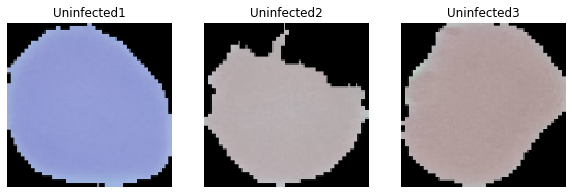

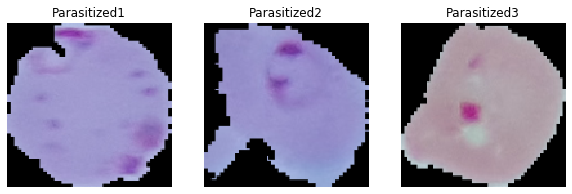

In [14]:
uninfected_images.standardizeResolution((128,128))
parasitized_images.standardizeResolution((128,128))

Shows the bounding box image and thresh image of five images from each class.

In [15]:
uninfected_images.viewBoundingBox(5)
parasitized_images.viewBoundingBox(5)

Shows bounding box and thresh image of five images from each class with the box being brought in closer by eight pixels on each side.

In [16]:
uninfected_images.viewBoundingBox(5,offset=8)
parasitized_images.viewBoundingBox(5,offset=8)

Converts all the images to numpy arrays.

In [17]:
uninfected_images.convert2NP()
parasitized_images.convert2NP()

Grayscales all images.

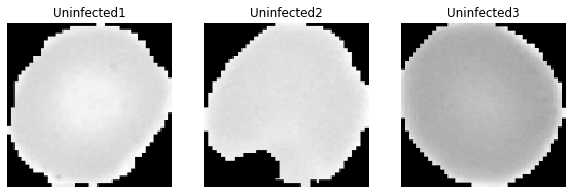

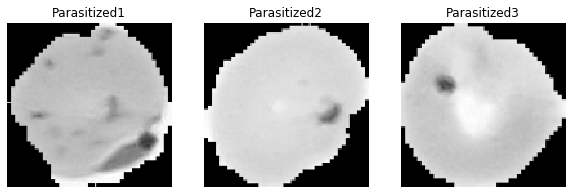

In [18]:
uninfected_images.grayscaleImages()
parasitized_images.grayscaleImages()

# 5) Baseline

Machine Learning: A standard logistic regression model takes an unreasonable amount of time on this task. A CNN on unaltered images is not particularly accurate either.

Current standard: 

Lab test(modern lab): As accurate as the lab good equipment and lab techs. Well-trained technicians are very accurate, and the test is standardized and simple. (CDC)

Lab test(ill-equipped lab): Can usually not properly analyze the specimen. (WHO)

"Rapid" test: These tests are done in the field and vary in accuracy. 

HRP2: Fast but about 50% accuracy many false positives. (NLM)

pLDH: Reaches 100% accuracy on day 7. (NLM)

Creates a pre-engineered set of images to be used as a baseline. Images labels are made.

In [19]:
baseline_uninfected = npImagePreprocessor(uninfected_images.getImages(),"Uninfected")
baseline_parasitized = npImagePreprocessor(parasitized_images.getImages(),"Parasitized")

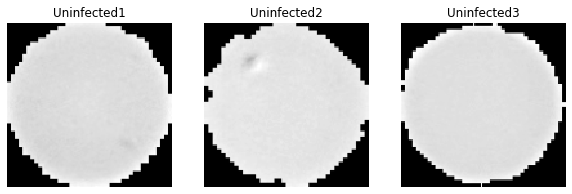

In [20]:
baseline_uninfected.showImages()

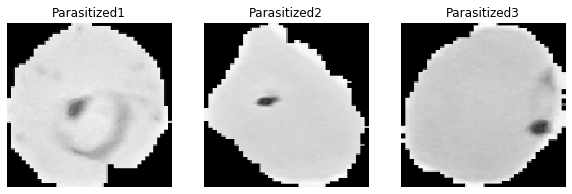

In [21]:
baseline_parasitized.showImages()

In [22]:
baseline_uninfected.makeLabels(0)
baseline_parasitized.makeLabels(1)

Makes a feature and label array from the baseline dataset.

(array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), (0, 1))


(-0.5, 127.5, 127.5, -0.5)

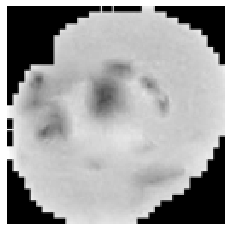

In [23]:
baseline_dataset = list()
makeDataset(baseline_dataset,baseline_uninfected.images_array,baseline_uninfected.labels)
makeDataset(baseline_dataset,baseline_parasitized.images_array,baseline_parasitized.labels)
random.shuffle(baseline_dataset)
print(baseline_dataset[0])
plt.imshow(baseline_dataset[0][0],cmap='gray')
plt.axis("off")

In [24]:
x = list()
y = list()
makeXYSets(baseline_dataset,x,y)

Turns both baseline lists into numpy arrays reshapes the feature array to the dimentions of the image and list (-1).

In [25]:
x = np.array(x).reshape(-1,128,128,1)
y= np.array(y)

In [26]:
print(x.shape)

(19561, 128, 128, 1)


Train test split 80% train 20% test.

In [27]:
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.8,stratify=y)

In [28]:
print(len(x_train))
print(len(x_test))

15648
3913


Baseline model is the same as the model that will be used for the engineered dataset. Will be discussed more later.

In [29]:
model = Sequential()

model.add(Conv2D(32,(3,3),activation="relu",input_shape=(128,128,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(32,(3,3),activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(32,(3,3),activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(32,(3,3),activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(64,activation="relu"))

model.add(Dense(256,activation="relu"))
model.add(Dropout(.33))

model.add(Dense(2,activation="softmax"))

model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [30]:
history = model.fit(x_train,y_train,batch_size=128,epochs=10,validation_split=0.2)

Train on 12518 samples, validate on 3130 samples
Epoch 1/10
12518/12518 [==============================] - 13s 1ms/sample - loss: 0.6308 - accuracy: 0.6575 - val_loss: 0.7981 - val_accuracy: 0.5022
Epoch 2/10
12518/12518 [==============================] - 7s 587us/sample - loss: 0.3348 - accuracy: 0.8530 - val_loss: 1.8227 - val_accuracy: 0.4978
Epoch 3/10
12518/12518 [==============================] - 7s 568us/sample - loss: 0.1829 - accuracy: 0.9372 - val_loss: 2.1603 - val_accuracy: 0.4978
Epoch 4/10
12518/12518 [==============================] - 7s 565us/sample - loss: 0.1503 - accuracy: 0.9465 - val_loss: 1.4866 - val_accuracy: 0.4978
Epoch 5/10
12518/12518 [==============================] - 7s 565us/sample - loss: 0.1357 - accuracy: 0.9542 - val_loss: 1.7332 - val_accuracy: 0.4757
Epoch 6/10
12518/12518 [==============================] - 7s 565us/sample - loss: 0.1299 - accuracy: 0.9539 - val_loss: 0.3779 - val_accuracy: 0.8514
Epoch 7/10
12518/12518 [============================

In [31]:
for i in range(5):
    print(i,y_test[i])
y_predict = model.predict(x_test)
for i in range(5):
    print(i,y_predict[i])

0 [0 1]
1 [0 1]
2 [0 1]
3 [0 1]
4 [1 0]
0 [0.00597927 0.99402076]
1 [3.6807504e-04 9.9963188e-01]
2 [2.7978794e-08 1.0000000e+00]
3 [6.8966284e-07 9.9999928e-01]
4 [0.58670807 0.4132919 ]


In [32]:
predict = list()
for x in range(len(y_predict)):
    predict.append(np.argmax(y_predict[x]))
test = list()
for x in range(len(y_test)):
    test.append(np.argmax(y_test[x]))
accuracy = accuracy_score(test,predict)
print('Accuracy is:', accuracy)

Accuracy is: 0.815742397137746


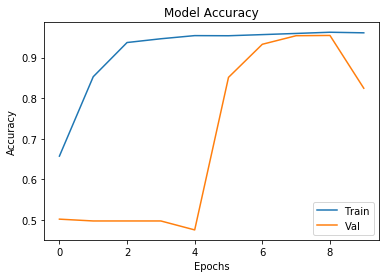

In [33]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","Val"], loc="lower right")
plt.show()

The baseline tends to overfit the train set and the validation set is volatile.

# 4B)Feature Engineering

Moves a bounding box in closer to the cell then changes all the pixels on the outside of the box to the center pixel color, and any area in the box with a low intensity to full intensity. This highlights the darker infected areas allowing for the gradient of the image to be magnified. The infected area is significantly different in intensity to that of the non-infected region.

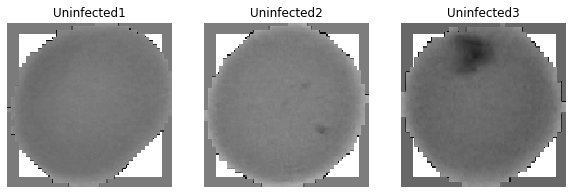

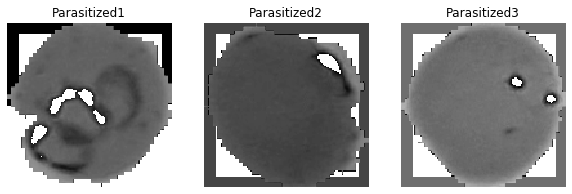

In [34]:
uninfected_images.magnifyGradient(0.38,offset=8)
parasitized_images.magnifyGradient(0.38,offset=8)

Creates a np array preprocessor object with the array from the previous preprocessor object.

In [35]:
uninfected_images_array = npImagePreprocessor(uninfected_images.getImages(),"Uninfected")
parasitized_images_array = npImagePreprocessor(parasitized_images.getImages(),"Parasitized")

Nomalizes pixels of the image from 0-1.

In [36]:
uninfected_images_array.normalizePixels()
parasitized_images_array.normalizePixels()

Finds the horizontal and vertical gradients of the images.

In [37]:
uninfected_images_array.gradient()
parasitized_images_array.gradient()

Plots the normal image and its gradients.

Uninfected


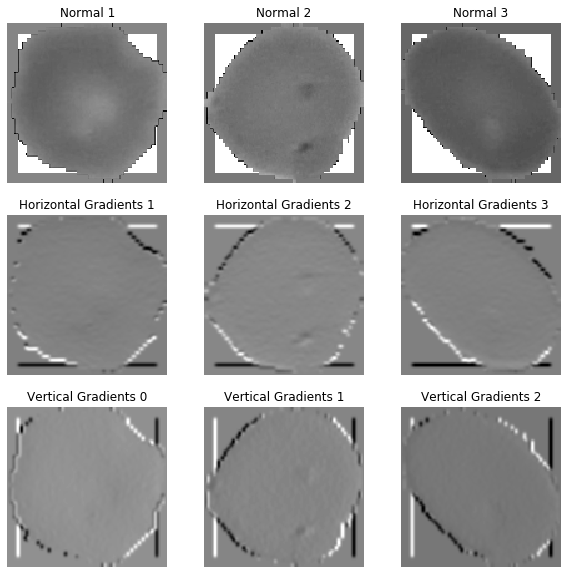

In [38]:
uninfected_images_array.showImages()

Parasitized


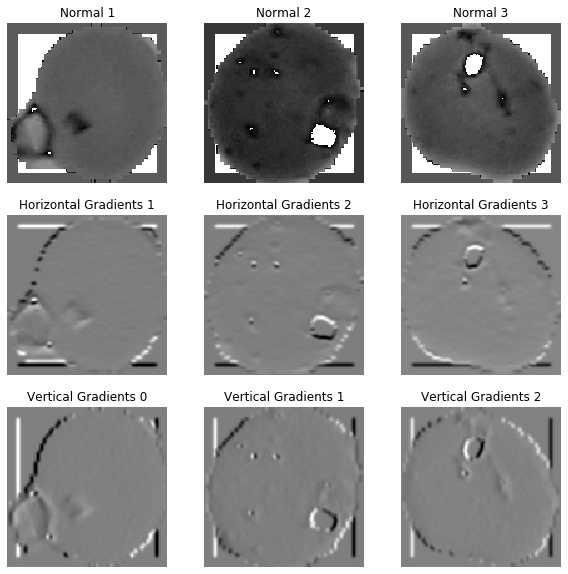

In [39]:
parasitized_images_array.showImages()

Creates labels for the classes 0 to uninfected and 1 to infected.

In [40]:
uninfected_images_array.makeLabels(0)
parasitized_images_array.makeLabels(1)

Dictionary of datasets.

In [41]:
datasets = {
    "Normal": list(),
    "Horizontal": list(),
    "Vertical": list()
}

Creates three datasets from the initial image containing the grayscaled normalized intensified original (Normal), and the horizontal and vertical gradients. Then a sample of each is printed.

(array([[0.66322078, 0.66322078, 0.66322078, ..., 0.66322078, 0.66322078,
        0.66322078],
       [0.66322078, 0.66322078, 0.66322078, ..., 0.66322078, 0.66322078,
        0.66322078],
       [0.66322078, 0.66322078, 0.66322078, ..., 0.66322078, 0.66322078,
        0.66322078],
       ...,
       [0.66322078, 0.66322078, 0.66322078, ..., 0.66322078, 0.66322078,
        0.66322078],
       [0.66322078, 0.66322078, 0.66322078, ..., 0.66322078, 0.66322078,
        0.66322078],
       [0.66322078, 0.66322078, 0.66322078, ..., 0.66322078, 0.66322078,
        0.66322078]]), (1, 0))


(-0.5, 127.5, 127.5, -0.5)

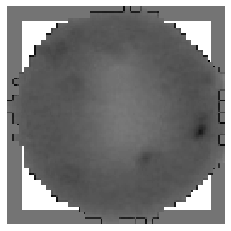

In [42]:
makeDataset(datasets["Normal"],uninfected_images_array.images_array,uninfected_images_array.labels)
makeDataset(datasets["Normal"],parasitized_images_array.images_array,parasitized_images_array.labels)
random.shuffle(datasets["Normal"])
print(datasets["Normal"][0])
plt.imshow(datasets["Normal"][0][0],cmap='gray')
plt.axis("off")

(array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), (0, 1))


(-0.5, 127.5, 127.5, -0.5)

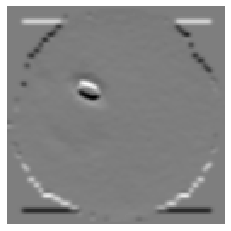

In [43]:
makeDataset(datasets["Horizontal"],uninfected_images_array.horizontal_gradients,uninfected_images_array.labels)
makeDataset(datasets["Horizontal"],parasitized_images_array.horizontal_gradients,parasitized_images_array.labels)
random.shuffle(datasets["Horizontal"])
print(datasets["Horizontal"][0])
plt.imshow(datasets["Horizontal"][0][0],cmap='gray')
plt.axis("off")

(array([[1.42108547e-14, 1.42108547e-14, 1.42108547e-14, ...,
        1.42108547e-14, 1.42108547e-14, 1.42108547e-14],
       [1.42108547e-14, 1.42108547e-14, 1.42108547e-14, ...,
        1.42108547e-14, 1.42108547e-14, 1.42108547e-14],
       [1.42108547e-14, 1.42108547e-14, 1.42108547e-14, ...,
        1.42108547e-14, 1.42108547e-14, 1.42108547e-14],
       ...,
       [1.42108547e-14, 1.42108547e-14, 1.42108547e-14, ...,
        1.42108547e-14, 1.42108547e-14, 1.42108547e-14],
       [1.42108547e-14, 1.42108547e-14, 1.42108547e-14, ...,
        1.42108547e-14, 1.42108547e-14, 1.42108547e-14],
       [1.42108547e-14, 1.42108547e-14, 1.42108547e-14, ...,
        1.42108547e-14, 1.42108547e-14, 1.42108547e-14]]), (0, 1))


(-0.5, 127.5, 127.5, -0.5)

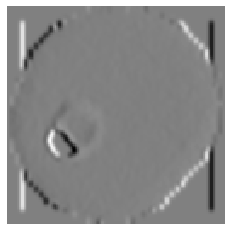

In [44]:
makeDataset(datasets["Vertical"],uninfected_images_array.vertical_gradients,uninfected_images_array.labels)
makeDataset(datasets["Vertical"],parasitized_images_array.vertical_gradients,parasitized_images_array.labels)
random.shuffle(datasets["Vertical"])
print(datasets["Vertical"][0])
plt.imshow(datasets["Vertical"][0][0],cmap='gray')
plt.axis("off")

# 6) Model

Makes a feature and label array from the horizontal dataset.

In [45]:
x = list()
y = list()
makeXYSets(datasets["Horizontal"],x,y)

Turns both lists into numpy arrays reshapes the feature array to the dimentions of the image and list (-1).

In [46]:
x = np.array(x).reshape(-1,128,128,1)
y= np.array(y)

In [47]:
print(x.shape)

(19561, 128, 128, 1)


Train test split 80% train 20% test.

In [48]:
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.8,stratify=y)

In [49]:
print(len(x_train))
print(len(x_test))

15648
3913


Sequential model with four convolutional maxpooling layers and two dense layers.

In [50]:
model = Sequential()

model.add(Conv2D(32,(3,3),activation="relu",input_shape=(128,128,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(32,(3,3),activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(32,(3,3),activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(32,(3,3),activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(64,activation="relu"))

model.add(Dense(256,activation="relu"))
model.add(Dropout(.33))

model.add(Dense(2,activation="softmax"))

model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

Model training.

In [51]:
history = model.fit(x_train,y_train,batch_size=128,epochs=10,validation_split=0.2)

Train on 12518 samples, validate on 3130 samples
Epoch 1/10
12518/12518 [==============================] - 11s 871us/sample - loss: 0.4130 - accuracy: 0.8171 - val_loss: 0.3402 - val_accuracy: 0.8617
Epoch 2/10
12518/12518 [==============================] - 8s 640us/sample - loss: 0.2368 - accuracy: 0.9058 - val_loss: 0.3007 - val_accuracy: 0.8895
Epoch 3/10
12518/12518 [==============================] - 7s 567us/sample - loss: 0.1770 - accuracy: 0.9355 - val_loss: 0.2316 - val_accuracy: 0.9304
Epoch 4/10
12518/12518 [==============================] - 7s 567us/sample - loss: 0.1561 - accuracy: 0.9454 - val_loss: 0.2010 - val_accuracy: 0.9335
Epoch 5/10
12518/12518 [==============================] - 7s 574us/sample - loss: 0.1416 - accuracy: 0.9503 - val_loss: 0.1393 - val_accuracy: 0.9498
Epoch 6/10
12518/12518 [==============================] - 7s 571us/sample - loss: 0.1306 - accuracy: 0.9516 - val_loss: 0.1471 - val_accuracy: 0.9498
Epoch 7/10
12518/12518 [==========================

Model structure.

In [52]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 126, 32)      320       
_________________________________________________________________
batch_normalization_4 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
batch_normalization_5 (Batch (None, 61, 61, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 32)       

Makes and shows prediction probabilities.

In [53]:
for i in range(5):
    print(i,y_test[i])
y_predict = model.predict(x_test)
for i in range(5):
    print(i,y_predict[i])

0 [1 0]
1 [1 0]
2 [1 0]
3 [0 1]
4 [1 0]
0 [0.97787845 0.02212151]
1 [0.9976903  0.00230971]
2 [0.99754375 0.00245623]
3 [0.0109768 0.9890232]
4 [0.9797245  0.02027549]


Counts incorrect predictions.

In [54]:
incorrect_images = list()
correct_labels = list()
for m in range(len(y_predict)):
    (a,b) = y_test[m]
    (c,d) = y_predict[m]
    if(c>=.5 and a == 0):
        incorrect_images.append(x_test[m])
        correct_labels.append(y_test[m])
    elif(d>.5 and b == 0):
        incorrect_images.append(x_test[m])
        correct_labels.append(y_test[m])
print(len(incorrect_images))

191


Shows metrics on test set.

In [55]:
predict = list()
for x in range(len(y_predict)):
    predict.append(np.argmax(y_predict[x]))
test = list()
for x in range(len(y_test)):
    test.append(np.argmax(y_test[x]))
accuracy = accuracy_score(test,predict)
print('Accuracy is:', accuracy)

Accuracy is: 0.9511883465371838


In [56]:
print(classification_report(test, predict))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      2001
           1       0.96      0.94      0.95      1912

    accuracy                           0.95      3913
   macro avg       0.95      0.95      0.95      3913
weighted avg       0.95      0.95      0.95      3913



Plots train and validation accuracy over epochs and loss function of train and val over epochs.

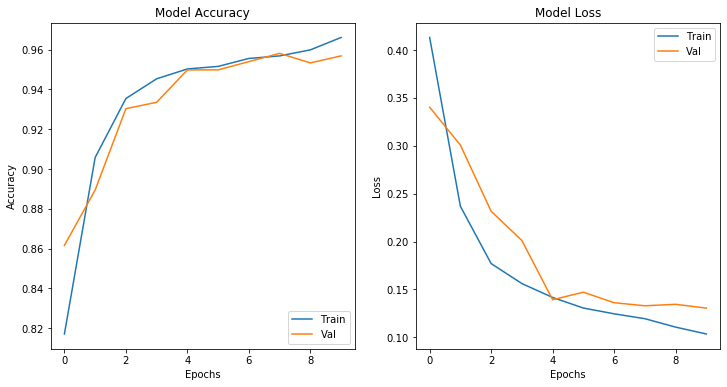

In [57]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","Val"], loc="lower right")

plt.subplot(122)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(['Train', 'Val'], loc='upper right')

plt.show()

In [58]:
'''Due to the sklearn method to plot not working this method had to be implimented 
inorder to properly plot a confusion matrix'''
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',normalize=False):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    plt.figure(figsize=(8, 6))
    plt.grid(b=False)
    plt.imshow(cm, interpolation='nearest', cmap="Blues")
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


Plots a confusion matrix to show were the model predicted incorrectly.

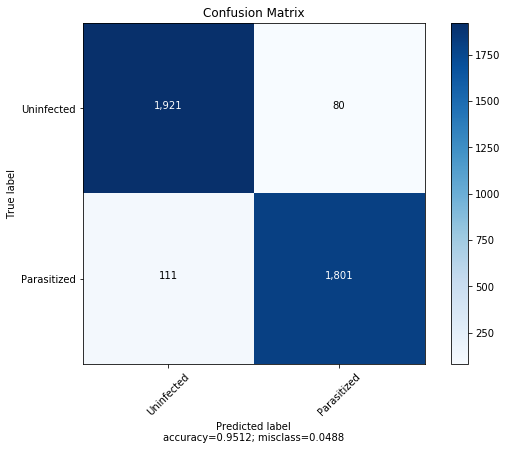

In [59]:
cm = confusion_matrix(test,predict)
plot_confusion_matrix(cm = cm,target_names = ["Uninfected","Parasitized"],title="Confusion Matrix")

Turns labels into strings.

In [60]:
for j in range(len(correct_labels)):
    if(correct_labels[j][0] == 1):
        correct_labels[j] = "Uninfected"
    elif(correct_labels[j][1] == 1):
        correct_labels[j] = "Parasitized"

Plots nine incorrect images.

Text(0.5, 1.0, 'Correct Label: Uninfected')

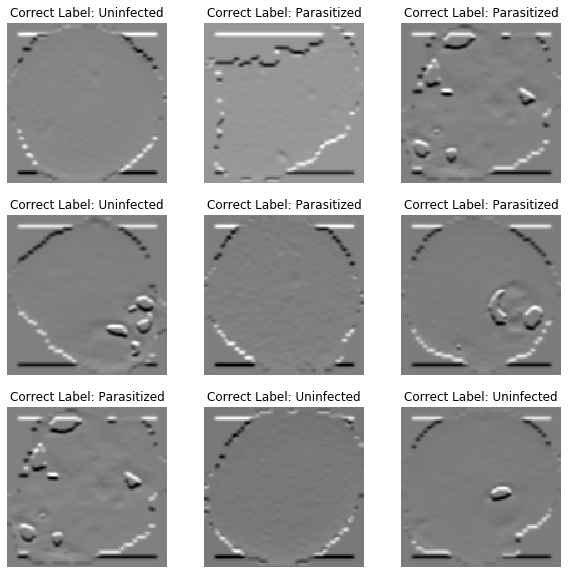

In [61]:
fig, (img0,img1,img2) = plt.subplots(3,3,figsize=(10,10))

indecies = getRandomIndex(len(incorrect_images),num_indecies=9)

img0[0].axis("off")
img0[0].imshow(np.array(x_test[indecies[0]]).reshape(128,128),cmap='gray')
img0[0].set_title("Correct Label: "+correct_labels[indecies[0]])

img1[0].axis("off")
img1[0].imshow(np.array(x_test[indecies[1]]).reshape(128,128),cmap='gray')
img1[0].set_title("Correct Label: "+correct_labels[indecies[1]])

img2[0].axis("off")
img2[0].imshow(np.array(x_test[indecies[2]]).reshape(128,128),cmap='gray')
img2[0].set_title("Correct Label: "+correct_labels[indecies[2]])

img0[1].axis("off")
img0[1].imshow(np.array(x_test[indecies[3]]).reshape(128,128),cmap='gray')
img0[1].set_title("Correct Label: "+correct_labels[indecies[3]])

img1[1].axis("off")
img1[1].imshow(np.array(x_test[indecies[4]]).reshape(128,128),cmap='gray')
img1[1].set_title("Correct Label: "+correct_labels[indecies[4]])

img2[1].axis("off")
img2[1].imshow(np.array(x_test[indecies[5]]).reshape(128,128),cmap='gray')
img2[1].set_title("Correct Label: "+correct_labels[indecies[5]])

img0[2].axis("off")
img0[2].imshow(np.array(x_test[indecies[6]]).reshape(128,128),cmap='gray')
img0[2].set_title("Correct Label: "+correct_labels[indecies[6]])

img1[2].axis("off")
img1[2].imshow(np.array(x_test[indecies[7]]).reshape(128,128),cmap='gray')
img1[2].set_title("Correct Label: "+correct_labels[indecies[7]])

img2[2].axis("off")
img2[2].imshow(np.array(x_test[indecies[8]]).reshape(128,128),cmap='gray')
img2[2].set_title("Correct Label: "+correct_labels[indecies[8]])



# 7) Deploy, Monitor, Maintain

## Deploy

To deploy this model, we could implement it in a modern lab setting where it can be verified against the highest current standard. If the model reaches or comes close to that current standard, then we could roll out the model to the areas that are in need of it. However, we could skip that initial set and move straight to deployment in the areas heavily affected by this disease.

## Monitor

In order to monitor our model, we can evaluate death rates against current records. If there were to be a spike in fatalities due to a lack of treatment, we would need to reevaluate the model. 

## Maintain

In order to maintain the model any advances in microscopic imaging technology for better photos or better test for showing an affected cell would need to be implemented. Any occurrence of issues with the model would need to be examined and thus any technique from new feature engineering to testing more of a person's cells could be used to improve the model.

# 8) Summary

Overall the model is preforming quite well. Accuracy is high and the model is efficient in its preprocessing and actual analysis of the images. Further feature engineering could be done to further highlight the areas that contain the parasite. Despite the engineered model only achieving a two-point increase this is not a fluke as running the model multiple times produced a consistent result on both sets. Therefore, we conclude that the additional augmentations to the data did improve the model. Further iterations to the model could include a more complex architecture to using multiple samples per-case and then aggregating the results to make a prediction based on the classification of multiple specimen’s vs just one.